In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score

# Keterangan Data

Data yang digunakan adalah data pelaporan SPT Tahunan tahun pajak 2016 s.d. 2020 dan pembayaran tahun 2016 s.d. 2021 yang akan digunakan untuk memprediksi seberapa besar kemungkinan wajib pajak akan lapor SPT pada tahun 2022

Kolom atau _features_ dalam data ini mencakup:
* NPWP - Nomor Pokok Wajib Pajak
* Nama - Nama Wajib Pajak
* JNS_WP - Jenis WP (Bendahara, Badan, OP Karyawan, OP Non Karyawan)
* Status WP - Normal/DE/Non Efeketif > Data yang digunakan hanya untuk wajib pajak yang berstatus aktif/normal
* Nama_AR - Nama _Account Representative_ penanggung jawab wajib pajak ybs
* Seksi - Seksi penangggung jawab WP ybs
* Lapor 2016 s.d. Lapor 2020 - Data Pelaporan WP tahun 2016 s.d. 2020
* Bendahara, OP Karyawan, OP Non Karyawan - One hot encoding untuk jenis WP, bila semuanya 0, jenis WP adalah WP badan
* Kolom 2016-2021 kolom pembayaran oleh WP ybs pada tahun 2016-2021

Data ini sudah dilakukan cleansing untuk mempermudah proses _modelling_ ke algoritma _machine learning_

# Split the Data into 3 Part: Train, Val, Test

The data will be split into:
1. 60% Train Data
2. 20% Validation Data
3. 20% Final Test Data

In [3]:
df = pd.read_parquet('data_cleaned.parquet')

In [5]:
df.head()

,NPWP,NAMA,JNS_WP,STATUS,NAMA_AR,SEKSI,LAPOR 2016,LAPOR 2017,LAPOR 2018,LAPOR 2019,LAPOR 2020,BENDAHARA,OP KARYAWAN,OP NON KARYAWAN,2016,2017,2018,2019,2020,2021
0,607109311045000,BUANG SUHARJO,OP KARYAWAN,Normal,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,774509673045000,OKKI ANDRIANI,OP KARYAWAN,Normal,TEGUH WIYONO,V,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,248790909045000,RENOLD DARMASYAH,OP KARYAWAN,Normal,AFRA PRAMUDYA NURJANAH,VI,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.174011,-0.041553,0.087869,0.177123,-0.059912,-0.065016
3,901134262045000,BUZER SIAGIAN,OP KARYAWAN,Normal,AHMAD IKHSANUDIN,II,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,577730740045000,AGUS SULAIMAN,OP KARYAWAN,Normal,ENCENG HELMI,III,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
df.columns

Index(['NPWP', 'NAMA', 'JNS_WP', 'STATUS', 'NAMA_AR', 'SEKSI', 'LAPOR 2016',
       'LAPOR 2017', 'LAPOR 2018', 'LAPOR 2019', 'LAPOR 2020', 'BENDAHARA',
       'OP KARYAWAN', 'OP NON KARYAWAN', '2016', '2017', '2018', '2019',
       '2020', '2021'],
      dtype='object')

In [7]:
feature_col = ['LAPOR 2016',
       'LAPOR 2017', 'LAPOR 2018', 'LAPOR 2019', 'BENDAHARA',
       'OP KARYAWAN', 'OP NON KARYAWAN', '2016', '2017', '2018', '2019',
       '2020']

In [9]:
X = df[feature_col]
y = df['LAPOR 2020']

In [10]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=21)

In [11]:
len(X_train), len(X_val), len(X_test)

(78647, 26216, 26216)

In [12]:
len(y_train), len(y_val), len(y_test)

(78647, 26216, 26216)

# XGBoost

In [31]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

In [32]:
xgb_model.fit(X_train.values, y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [33]:
xgb_pred_1 = xgb_model.predict(X_val)

In [61]:
accuracy_score(y_val, xgb_pred_1)

0.8621833994507171

In [47]:
xgb_model_grid = xgb.XGBClassifier(objective='binary:logistic')

In [48]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [49]:
grid_cv = GridSearchCV(xgb_model_grid, param_grid=param_grid, verbose=3)

In [50]:
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.867 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.6s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.864 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.840 total time=  

[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.829 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.835 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.831 total time=   0.8s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.816 total time=   0.8s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.812 total time=   0.8s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.808 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=

[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.867 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   1.0s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.863 total time=   1.0s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.864 total time=   1.0s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   1.1s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.835 total time=   1.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=

[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=7, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.834 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=7, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.831 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=7, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.817 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=7, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.814 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=7, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.811 total time=   1.2s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=7, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.817 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=

[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.856 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.856 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.832 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.837 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.835 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.811 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=0, le

[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.806 total time=   0.9s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.810 total time=   0.9s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.805 total time=   0.9s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.597 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.594 total time=   0.9s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.591 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0, le

[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.591 total time=   0.9s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.856 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.856 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.833 total time=   1.2s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.839 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.836 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learnin

[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.816 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.814 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.821 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.814 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.810 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.809 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning

[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.813 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.807 total time=   0.8s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.867 total time=   0.8s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   0.8s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.864 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning

[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.819 total time=   1.0s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.814 total time=   1.0s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.810 total time=   0.9s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.817 total time=   1.0s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.811 total time=   1.0s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.815 total time=   1.0s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning

[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.808 total time=   1.2s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.814 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.807 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.867 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   1.2s
[CV 4/5] END colsample_bytree=0.5, gamma=0, learn

[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.836 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.835 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.836 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.840 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.837 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5,

[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.811 total time=   0.8s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.809 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.815 total time=   0.9s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.809 total time=   0.8s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.867 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   0.9s
[CV 3/5] END colsample_bytree=0.5, g

[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.864 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.863 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=7, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.835 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=7, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.833 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=7, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.828 total time=   1.2s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.1, max_depth=7, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.834 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma

[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.597 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.595 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.593 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.591 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.594 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.856 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5,

[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.855 total time=   0.8s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.829 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.839 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.835 total time=   0.8s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.813 total time=   0.8s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.809 total time=   0.8s
[CV 3/5] END colsample_bytree=0.5,

[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.808 total time=   1.0s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.813 total time=   1.0s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.807 total time=   1.0s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.597 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.595 total time=   0.9s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.592 total time=   1.0s
[CV 4/5] END colsample_bytree=0.5,

[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=7, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.594 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=7, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.595 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.857 total time=   1.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.855 total time=   1.1s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.833 total time=   1.1s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.01, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.839 total time=   1.1s
[CV 5/5] END colsample_bytree=

[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.820 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.816 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.814 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.821 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.813 total time=   0.7s
[CV 1/5] END colsample_bytre

[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.814 total time=   0.8s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.810 total time=   0.8s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.806 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.811 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.807 total time=   0.8s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.867 total time=   0.9s
[CV 2/5] END colsample_bytree

[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   1.2s
[CV 4/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.864 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=7, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=7, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.819 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0.25, learning_rate=0.05, max_depth=7, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.816 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5,

[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.835 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.840 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.837 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.816 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.812 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.808 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=

[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.867 total time=   0.8s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   0.8s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.865 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=4, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.8s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=4, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.835 total time=   0.8s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=

[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.834 total time=   0.9s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.831 total time=   0.9s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.817 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.813 total time=   0.9s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.809 total time=   1.0s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.815 total time=   1.0s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=

[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   1.2s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.864 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=7, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=7, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.834 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.1, max_depth=7, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.833 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning

[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.809 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.804 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.597 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.595 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.593 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=3, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.591 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=1, le

[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.857 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.856 total time=   1.0s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.830 total time=   1.0s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.839 total time=   1.0s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1, subsample=0.8;, score=0.836 total time=   1.0s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.815 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning

[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.808 total time=   1.2s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.814 total time=   1.3s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=3, subsample=0.8;, score=0.808 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.600 total time=   1.3s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.597 total time=   1.5s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=7, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.595 total time=   1.3s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning

[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5, subsample=0.8;, score=0.803 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=3, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.867 total time=   0.7s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=3, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   0.7s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=3, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=3, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.863 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=3, reg_lambda=1, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.7s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning

[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.814 total time=   0.8s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.811 total time=   0.8s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.817 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=3, subsample=0.8;, score=0.810 total time=   0.9s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.815 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=4, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.810 total time=   1.0s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning

[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.813 total time=   0.9s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=5, reg_lambda=1, scale_pos_weight=5, subsample=0.8;, score=0.807 total time=   1.0s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=5, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.867 total time=   1.0s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=5, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.866 total time=   0.9s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=5, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.862 total time=   0.9s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=5, reg_lambda=10, scale_pos_weight=1, subsample=0.8;, score=0.864 total time=   0.9s
[CV 5/5] END colsample_bytree=0.5, gamma=1, lear

[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=7, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.819 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=7, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.814 total time=   1.2s
[CV 3/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=7, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.810 total time=   1.3s
[CV 4/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=7, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.817 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=7, reg_lambda=10, scale_pos_weight=3, subsample=0.8;, score=0.811 total time=   1.2s
[CV 1/5] END colsample_bytree=0.5, gamma=1, learning_rate=0.05, max_depth=7, reg_lambda=10, scale_pos_weight=5, subsample=0.8;, score=0.814 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, gamma=1, le

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     n

In [51]:
grid_cv.best_score_

0.864533874508386

In [52]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 5,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [53]:
xgb_model_2 = xgb.XGBClassifier(**grid_cv.best_params_)

In [54]:
xgb_model_2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [55]:
xgb_pred_2 = xgb_model_2.predict(X_val)

In [56]:
accuracy_score(y_val, xgb_pred_2)

0.8630607262740311

# Logistic Regression

In [57]:
logmodel = LogisticRegression()

In [58]:
logmodel.fit(X_train, y_train)

LogisticRegression()

In [59]:
log_preds = logmodel.predict(X_val)

In [60]:
accuracy_score(y_val, log_preds)

0.8628318584070797

# DNN

In [62]:
len(X_train.columns)

12

In [63]:
X_train.shape

(78647, 12)

In [77]:
# Create DNN Model

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12,activation='relu',input_shape=[12]),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

In [78]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 12)                156       
                                                                 
 dense_17 (Dense)            (None, 6)                 78        
                                                                 
 dense_18 (Dense)            (None, 3)                 21        
                                                                 
 dense_19 (Dense)            (None, 1)                 4         
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.fit(X_train.values, 
          y_train.values,
          callbacks=early_stop,
          epochs=200,
          validation_data=(X_val, y_val))

Epoch 1/200
2458/2458 [==============================] - 16s 6ms/step - loss: 0.3954 - accuracy: 0.8562 - val_loss: 0.3699 - val_accuracy: 0.8628
Epoch 2/200
2458/2458 [==============================] - 16s 6ms/step - loss: 0.3683 - accuracy: 0.8638 - val_loss: 0.3685 - val_accuracy: 0.8628
Epoch 3/200
2458/2458 [==============================] - 16s 7ms/step - loss: 0.3680 - accuracy: 0.8638 - val_loss: 0.3689 - val_accuracy: 0.8628
Epoch 4/200
2458/2458 [==============================] - 16s 7ms/step - loss: 0.3673 - accuracy: 0.8639 - val_loss: 0.3682 - val_accuracy: 0.8628
Epoch 5/200
2458/2458 [==============================] - 16s 7ms/step - loss: 0.3669 - accuracy: 0.8641 - val_loss: 0.3685 - val_accuracy: 0.8625
Epoch 6/200
2458/2458 [==============================] - 16s 6ms/step - loss: 0.3663 - accuracy: 0.8639 - val_loss: 0.3680 - val_accuracy: 0.8627
Epoch 7/200
2458/2458 [==============================] - 16s 6ms/step - loss: 0.3661 - accuracy: 0.8641 - val_loss: 0.3678 -

In [80]:
history = pd.DataFrame(model.history.history)

In [83]:
history

,loss,accuracy,val_loss,val_accuracy
0,0.395416,0.856167,0.369904,0.862756
1,0.368300,0.863796,0.368463,0.862756
2,0.368049,0.863822,0.368927,0.862832
3,0.367271,0.863885,0.368218,0.862832
4,0.366919,0.864064,0.368451,0.862489
5,0.366333,0.863936,0.368015,0.862717
6,0.366133,0.864076,0.367804,0.862832
7,0.365994,0.864102,0.369262,0.862870
8,0.365832,0.864025,0.368031,0.862870


<AxesSubplot:>

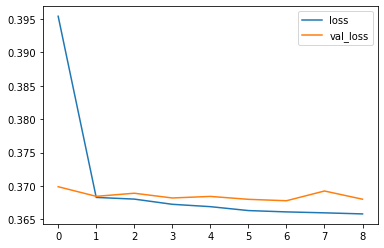

In [84]:
history[['loss','val_loss']].plot()

<AxesSubplot:>

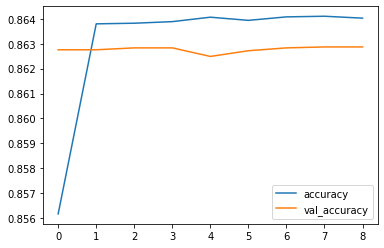

In [85]:
history[['accuracy','val_accuracy']].plot()

In [91]:
dnn_preds = model.predict(X_val.values)

820/820 [==============================] - 2s 2ms/step


In [92]:
accuracy_score(y_val, (tf.squeeze(dnn_preds)>0.5))

0.8628700030515716

# Evaluation on the Test set

In [108]:
final_xgb_pred = xgb_model_2.predict_proba(X_test)[:,1]
final_log_pred = logmodel.predict_proba(X_test)[:,1]
final_dnn_pred = model.predict(X_test.values)

820/820 [==============================] - 2s 2ms/step


In [110]:
accuracy_score(y_test, (final_xgb_pred>0.5)), accuracy_score(y_test, (final_log_pred>0.5)), accuracy_score(y_test, (tf.squeeze(final_dnn_pred)>0.5))

(0.8631370155630149, 0.8626029905401281, 0.8624122673176686)

In [101]:
final_xgb_pred[:,1] > 0.5

array([False, False, False, ...,  True,  True, False])

In [98]:
xgb_model_2.predict(X_test)

array([0, 0, 0, ..., 1, 1, 0])

In [104]:
final_log_pred

array([[0.87448136, 0.12551864],
       [0.51788669, 0.48211331],
       [0.87448136, 0.12551864],
       ...,
       [0.07992311, 0.92007689],
       [0.28159761, 0.71840239],
       [0.92942263, 0.07057737]])

In [105]:
logmodel.predict(X_test)

array([0., 0., 0., ..., 1., 1., 0.])

In [151]:
final_pred_1 = (0.6*final_xgb_pred+0*final_log_pred+0.4*tf.squeeze(final_dnn_pred))

In [152]:
accuracy_score(y_test, (final_pred_1 > 0.5))

0.863098870918523

In [153]:
print(classification_report(y_test, (final_pred_1 > 0.5)))

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88     14851
         1.0       0.87      0.80      0.84     11365

    accuracy                           0.86     26216
   macro avg       0.86      0.86      0.86     26216
weighted avg       0.86      0.86      0.86     26216



# Train on all Data

In [159]:
xgb_model_final = xgb.XGBClassifier(objective='binary:logistic',
                                   colsample_bytree=0.5,
                                   gamma=0,
                                   learning_rate=0.05,
                                   max_depth=5,
                                   reg_lambda=1,
                                   scale_pos_weight=1,
                                   subsample=0.8)

In [160]:
xgb_model_final.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [161]:
import joblib

In [162]:
joblib.dump(xgb_model_final, 'xgb_model.pkl')

['xgb_model.pkl']

In [158]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 5,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [166]:
final_dnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12,activation='relu',input_shape=[12]),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

final_dnn.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [167]:
final_dnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 12)                156       
                                                                 
 dense_25 (Dense)            (None, 6)                 78        
                                                                 
 dense_26 (Dense)            (None, 3)                 21        
                                                                 
 dense_27 (Dense)            (None, 1)                 4         
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


In [168]:
final_dnn.fit(X.values, y.values, epochs=8)

Epoch 1/8
4097/4097 [==============================] - 24s 6ms/step - loss: 0.4179 - accuracy: 0.8599
Epoch 2/8
4097/4097 [==============================] - 24s 6ms/step - loss: 0.3732 - accuracy: 0.8633
Epoch 3/8
4097/4097 [==============================] - 24s 6ms/step - loss: 0.3691 - accuracy: 0.8635
Epoch 4/8
4097/4097 [==============================] - 24s 6ms/step - loss: 0.3680 - accuracy: 0.8636
Epoch 5/8
4097/4097 [==============================] - 24s 6ms/step - loss: 0.3673 - accuracy: 0.8634
Epoch 6/8
4097/4097 [==============================] - 24s 6ms/step - loss: 0.3667 - accuracy: 0.8635
Epoch 7/8
4097/4097 [==============================] - 24s 6ms/step - loss: 0.3666 - accuracy: 0.8636
Epoch 8/8
4097/4097 [==============================] - 23s 6ms/step - loss: 0.3666 - accuracy: 0.8634


In [169]:
final_dnn.save('DNN_predictor.h5')